# Imports

In [219]:
from os import walk # walk funtion
from os.path import  join # join method
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

import nltk
from nltk.stem import PorterStemmer
from nltk.stem import SnowballStemmer # Other option than PortStremmer
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

from bs4 import BeautifulSoup # Removing HTML tags
from wordcloud import WordCloud
from PIL import Image # PIL(pillow) for image manipulation 

from sklearn.model_selection import train_test_split

%matplotlib inline

# Constants

In [221]:
EXAMPLE_FILE = "C:/Users/HP/Data Science/ML/SpamData/01_Processing/practice_email.txt"

SPAM_1_PATH = "C:/Users/HP/Data Science/ML/SpamData/01_Processing/spam_assassin_corpus/spam_1"
SPAM_2_PATH = "C:/Users/HP/Data Science/ML/SpamData/01_Processing/spam_assassin_corpus/spam_2"
EASY_NONSPAM_1_PATH = "C:/Users/HP/Data Science/ML/SpamData/01_Processing/spam_assassin_corpus/easy_ham_1"
EASY_NONSPAM_2_PATH = "C:/Users/HP/Data Science/ML/SpamData/01_Processing/spam_assassin_corpus/easy_ham_2"

SPAM_CAT = 1
HAM_CAT = 0
VOCAB_SIZE = 2500

DATA_JSON_FILE = "C:/Users/HP/Data Science/ML/email-text-data.json"
WORD_ID_FILE = "C:/Users/HP/Data Science/ML/word-by-id.csv"

TRAINING_DATA_FILE = "C:/Users/HP/Data Science/ML/SpamData/02_Training/train-data.txt"
TEST_DATA_FILE = "C:/Users/HP/Data Science/ML/SpamData/02_Training/test-data.txt"

WHALE_FILE = "C:/Users/HP/Data Science/ML/SpamData/01_Processing/wordcloud_resources/whale-icon.png"
THUMBS_UP_FILE = "C:/Users/HP/Data Science/ML/SpamData/01_Processing/wordcloud_resources/thumbs-up.png"
THUMBS_DOWN_FILE = "C:/Users/HP/Data Science/ML/SpamData/01_Processing/wordcloud_resources/thumbs-down.png"
CUSTOM_FONT_FILE = "C:/Users/HP/Data Science/ML/SpamData/01_Processing/wordcloud_resources/OpenSansCondensed-Bold.TTF"

TOKEN_SPAM_PROB_FILE = "C:/Users/HP/Data Science/ML/SpamData/03_Testing/prob-spam.txt"
TOKEN_HAM_PROB_FILE = "C:/Users/HP/Data Science/ML/SpamData/03_Testing/prob-nonspam.txt"
TOKEN_ALL_PROB_FILE = "C:/Users/HP/Data Science/ML/SpamData/03_Testing/prob-all-tokens.txt"

TEST_FEATURES_MATRIX = "C:/Users/HP/Data Science/ML/SpamData/03_Testing/test-features.txt"
TEST_TARGET_FILE = "C:/Users/HP/Data Science/ML/SpamData/03_Testing/test-target.txt"

VOCAB_SIZE = 2500

# Reading File

In [19]:
stream = open(EXAMPLE_FILE, encoding="latin-1") # Opening the file
message = stream.read() # saving the file into a variable
stream.close() # Closing the file

print(type(message))
print(message)

<class 'str'>
From exmh-workers-admin@redhat.com  Thu Aug 22 12:36:23 2002
Return-Path: <exmh-workers-admin@spamassassin.taint.org>
Delivered-To: zzzz@localhost.netnoteinc.com
Received: from localhost (localhost [127.0.0.1])
	by phobos.labs.netnoteinc.com (Postfix) with ESMTP id D03E543C36
	for <zzzz@localhost>; Thu, 22 Aug 2002 07:36:16 -0400 (EDT)
Received: from phobos [127.0.0.1]
	by localhost with IMAP (fetchmail-5.9.0)
	for zzzz@localhost (single-drop); Thu, 22 Aug 2002 12:36:16 +0100 (IST)
Received: from listman.spamassassin.taint.org (listman.spamassassin.taint.org [66.187.233.211]) by
    dogma.slashnull.org (8.11.6/8.11.6) with ESMTP id g7MBYrZ04811 for
    <zzzz-exmh@spamassassin.taint.org>; Thu, 22 Aug 2002 12:34:53 +0100
Received: from listman.spamassassin.taint.org (localhost.localdomain [127.0.0.1]) by
    listman.redhat.com (Postfix) with ESMTP id 8386540858; Thu, 22 Aug 2002
    07:35:02 -0400 (EDT)
Delivered-To: exmh-workers@listman.spamassassin.taint.org
Received: fro

In [20]:
# used to retrive default encoding used vy the file system
import sys
sys.getfilesystemencoding()

'utf-8'

## Email Body Extraction
    

In [22]:
def email_body_generator(path):

    # walk funtion belong to os library so we have to import it
    for root, dirnames, filenames in walk(path): 
        
#"""walk funtion generate file name in directory by walking the tree from top to bottom and yeld tuples consisting of directory path (root),
#directory name (dirname) and file name.""" 

        for file_name in filenames:

            filepath = join(root,file_name) # targeting a paticular file by combining root and file name
            
            stream = open(filepath, encoding="latin-1") # using filepath

            is_body = False 
            lines = []
            for line in stream:
                if is_body: 
                    lines.append(line)
                elif line == "\n": 
                    is_body = True
            
            stream.close() 

            email_body ="n".join(lines)

            yield file_name, email_body
    

In [61]:
# Second piece of code to call generative function
# df = dataframe
def df_from_directory(path, classification): #classification weather the email is spam or legit
    rows = []
    row_name = []

    for file_name, email_body in email_body_generator(path):
        rows.append({"MESSAGE": email_body, "CATEGORY": classification})
        row_name.append(file_name)

    return pd.DataFrame(rows, index = row_name)

In [65]:
#Creating dataframe with spam emails
# Lokking in spam_1_path folder
spam_1_emails = df_from_directory(SPAM_1_PATH, 1)
# loading our other folders
spam_2_emails = df_from_directory(SPAM_2_PATH, 1) #overriding spam_email with spam_2_path
#Concat both spam
spam_result = pd.concat([spam_1_emails, spam_2_emails]) 


In [67]:
spam_result.shape

(1898, 2)

In [69]:
#Creating dataframe with non-spam emails
ham_1_emails = df_from_directory(EASY_NONSPAM_1_PATH, HAM_CAT)
ham_2_emails = df_from_directory(EASY_NONSPAM_2_PATH, HAM_CAT)
ham_result = pd.concat([ham_1_emails, ham_2_emails])

In [71]:
data = pd.concat([spam_result, ham_result])

# Data Cleaning: Checking for missing values

In [74]:
type(data.MESSAGE.str.len() == 0)

pandas.core.series.Series

In [76]:
data[data.MESSAGE.str.len() == 0].index

Index(['cmds', 'cmds', 'cmds'], dtype='object')

In [78]:
data.index.get_loc("cmds")

array([False, False, False, ..., False, False, False])

## Removing system file entries from the dataframe

In [81]:
data.drop(["cmds"], inplace=True)

In [83]:
data.shape

(5796, 2)

## Add documents ID to track Email in dataset

In [86]:
# Generative documents id
document_ids = range(0,len(data.index))
data["DOC_ID"] = document_ids

In [88]:
data.DOC_ID

00001.7848dde101aa985090474a91ec93fcf0       0
00002.d94f1b97e48ed3b553b3508d116e6a09       1
00003.2ee33bc6eacdb11f38d052c44819ba6c       2
00004.eac8de8d759b7e74154f142194282724       3
00005.57696a39d7d84318ce497886896bf90d       4
                                          ... 
01396.61983fbe6ec43f55fd44e30fce24ffa6    5791
01397.9f9ef4c2a8dc012d80f2ce2d3473d3b7    5792
01398.169b51731fe569f42169ae8f948ec676    5793
01399.ca6b00b7b341bbde9a9ea3dd6a7bf896    5794
01400.f897f0931e461e7b2e964d28e927c35e    5795
Name: DOC_ID, Length: 5796, dtype: int64

In [90]:
data["FILE_NAME"] = data.index
# setting the index equal to document ids
data.set_index("DOC_ID", inplace=True)
data.head()

,MESSAGE,CATEGORY,FILE_NAME
DOC_ID,,,
0,"<!DOCTYPE HTML PUBLIC ""-//W3C//DTD HTML 4.0 Tr...",1,00001.7848dde101aa985090474a91ec93fcf0
1,1) Fight The Risk of Cancer!\nnhttp://www.adcl...,1,00002.d94f1b97e48ed3b553b3508d116e6a09
2,1) Fight The Risk of Cancer!\nnhttp://www.adcl...,1,00003.2ee33bc6eacdb11f38d052c44819ba6c
3,##############################################...,1,00004.eac8de8d759b7e74154f142194282724
4,I thought you might like these:\nn1) Slim Down...,1,00005.57696a39d7d84318ce497886896bf90d


## Number of spam messages visualised (Pie chart)

In [93]:
amount_of_spam = data.CATEGORY.value_counts()[1]
amount_of_ham = data.CATEGORY.value_counts()[0]

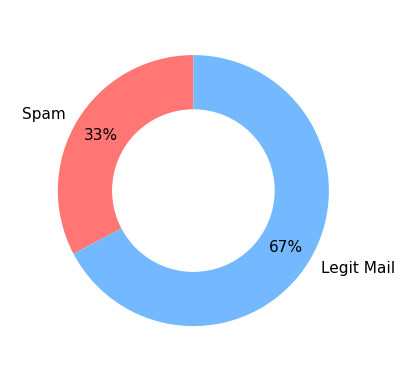

In [97]:
category_name = ["Spam","Legit Mail"]
sizes = [amount_of_spam, amount_of_ham]
custom_colours = ["#ff7675", "#74b9ff"] # adding colour to a list 

plt.figure(figsize=(2,2), dpi=220) 
plt.pie(sizes, labels=category_name, textprops={"fontsize":5}, startangle=90,
        autopct="%1.0f%%", colors=custom_colours, pctdistance=0.8) 
# percent_distance to distance percent = pctdistance


# Create donught chart
# Draw cirlce
centre_circle = plt.Circle((0,0), radius=0.6, fc="white")
plt.gca().add_artist(centre_circle) # gca = get the current axis and adding circle with .add_artist

plt.show()

# Text Pre-Processing

### Download the NLTK Resources (Tokenizer & Stopwords)

In [103]:
nltk.download("punkt")

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\HP\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [104]:
nltk.download("stopwords")

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\HP\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

### Tokenising

In [112]:
# Tokenizing using NLP
msg = "All work and no play makes Jack a dull boy."
word_tokenize(msg.lower())

['all', 'work', 'and', 'no', 'play', 'makes', 'jack', 'a', 'dull', 'boy', '.']

### Removing stopwords

In [117]:
stop_words = set(stopwords.words("english"))

In [119]:
# creating function that can lower, tokenize and remove stopwords
msg = "All work and no play makes Jack a dull boy. To be or not to be."
words = word_tokenize(msg.lower())

filtered_words = []

for word in words:
    if word not in stop_words:
        filtered_words.append(word)

print(filtered_words)

['work', 'play', 'makes', 'jack', 'dull', 'boy', '.', '.']


### Removing Punctuations

In [125]:
# creating function that can lower, tokenize and remove stopwords
msg = "All work and no play makes Jack a dull boy. To be or not to be. \
Nobody expects the Spanish Inquisition!"
words = word_tokenize(msg.lower())

#stemmer = PorterStemmer()
stemmer = SnowballStemmer("english")
filtered_words = []

for word in words:
    if word not in stop_words:
        stemmed_word = stemmer.stem(word)
        filtered_words.append(stemmed_word)

print(filtered_words)

['work', 'play', 'make', 'jack', 'dull', 'boy', '.', '.', 'nobodi', 'expect', 'spanish', 'inquisit', '!']


## Removing HTML tags from emails

In [128]:
soup = BeautifulSoup(data.at[2, "MESSAGE"], "html.parser") 
print(soup.prettify())

1) Fight The Risk of Cancer!
nhttp://www.adclick.ws/p.cfm?o=315&amp;s=pk007
n
n2) Slim Down - Guaranteed to lose 10-12 lbs in 30 days
nhttp://www.adclick.ws/p.cfm?o=249&amp;s=pk007
n
n3) Get the Child Support You Deserve - Free Legal Advice
nhttp://www.adclick.ws/p.cfm?o=245&amp;s=pk002
n
n4) Join the Web's Fastest Growing Singles Community
nhttp://www.adclick.ws/p.cfm?o=259&amp;s=pk007
n
n5) Start Your Private Photo Album Online!
nhttp://www.adclick.ws/p.cfm?o=283&amp;s=pk007
n
nHave a Wonderful Day,
nOffer Manager
nPrizeMama
n
n
n
n
n
n
n
n
n
n
n
n
n
nIf you wish to leave this list please use the link below.
nhttp://www.qves.com/trim/?zzzz@spamassassin.taint.org%7C17%7C308417
n



In [130]:
soup.get_text()

"1) Fight The Risk of Cancer!\nnhttp://www.adclick.ws/p.cfm?o=315&s=pk007\nn\nn2) Slim Down - Guaranteed to lose 10-12 lbs in 30 days\nnhttp://www.adclick.ws/p.cfm?o=249&s=pk007\nn\nn3) Get the Child Support You Deserve - Free Legal Advice\nnhttp://www.adclick.ws/p.cfm?o=245&s=pk002\nn\nn4) Join the Web's Fastest Growing Singles Community\nnhttp://www.adclick.ws/p.cfm?o=259&s=pk007\nn\nn5) Start Your Private Photo Album Online!\nnhttp://www.adclick.ws/p.cfm?o=283&s=pk007\nn\nnHave a Wonderful Day,\nnOffer Manager\nnPrizeMama\nn\nn\nn\nn\nn\nn\nn\nn\nn\nn\nn\nn\nn\nnIf you wish to leave this list please use the link below.\nnhttp://www.qves.com/trim/?zzzz@spamassassin.taint.org%7C17%7C308417\nn\n"

## Function for Email Processing

In [137]:
def clean_msg_no_html(message, stemmer=PorterStemmer(), 
                  stop_words = set(stopwords.words("english"))):

    # Remove HTML tags
    soup = BeautifulSoup(message, "html.parser")
    cleaned_text = soup.get_text()
    
    # Converts to lowercase and splits the words
    words = word_tokenize(cleaned_text.lower())
    
    filtered_words = []

    for word in words:
        # Remove the stop word and Punctuation
        if word not in stop_words and word.isalpha():
            filtered_words.append(stemmer.stem(word))

    return filtered_words

In [139]:
clean_msg_no_html(data.at[2, "MESSAGE"])

['fight',
 'risk',
 'cancer',
 'nhttp',
 'n',
 'slim',
 'guarante',
 'lose',
 'lb',
 'day',
 'nhttp',
 'n',
 'get',
 'child',
 'support',
 'deserv',
 'free',
 'legal',
 'advic',
 'nhttp',
 'n',
 'join',
 'web',
 'fastest',
 'grow',
 'singl',
 'commun',
 'nhttp',
 'n',
 'start',
 'privat',
 'photo',
 'album',
 'onlin',
 'nhttp',
 'n',
 'nhave',
 'wonder',
 'day',
 'noffer',
 'manag',
 'nprizemama',
 'n',
 'n',
 'n',
 'n',
 'n',
 'n',
 'n',
 'n',
 'n',
 'n',
 'n',
 'n',
 'n',
 'nif',
 'wish',
 'leav',
 'list',
 'pleas',
 'use',
 'link',
 'nhttp',
 'zzzz',
 'n']

### Applying Cleaning and Tokenisation to all messages

In [144]:
first_emails = data.MESSAGE.iloc[0:3]
nested_list = first_emails.apply(clean_message)

In [146]:
flat_list = [item for sublist in nested_list for item in sublist]

len(flat_list)

447

In [148]:
%%time

# use apply() on all the messages in th edataframe
nested_list = data.MESSAGE.apply(clean_msg_no_html)

C:\Users\HP\AppData\Local\Temp\ipykernel_13204\590979557.py:5: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  soup = BeautifulSoup(message, "html.parser")
C:\Users\HP\AppData\Local\Temp\ipykernel_13204\590979557.py:5: MarkupResemblesLocatorWarning: The input looks more like a URL than markup. You may want to use an HTTP client like requests to get the document behind the URL, and feed that document to Beautiful Soup.
  soup = BeautifulSoup(message, "html.parser")


CPU times: total: 58.8 s
Wall time: 1min


In [150]:
nested_list.head()

DOC_ID
0    [n, n, n, n, n, n, n, n, n, n, n, n, n, n, nsa...
1    [fight, risk, cancer, nhttp, n, slim, guarante...
2    [fight, risk, cancer, nhttp, n, slim, guarante...
3    [n, n, adult, club, n, offer, free, membership...
4    [thought, might, like, slim, guarante, lose, l...
Name: MESSAGE, dtype: object

### Using Logic to slice dataframes

In [155]:
# create two variables for spam and non spam emails index
doc_ids_spam = data[data.CATEGORY == 1].index
doc_ids_ham = data[data.CATEGORY == 0].index

### Subsetting a series with an index

In [160]:
nested_list_ham = nested_list.loc[doc_ids_ham]

In [162]:
nested_list_spam = nested_list.loc[doc_ids_spam]

In [164]:
# Creating flat list from nested list to count unique words in ham
flat_list_ham = [item for sublist in nested_list_ham for item in sublist]
normal_words = pd.Series(flat_list_ham).value_counts() # value_counts() create series of unique words

normal_words.shape[0] # total number of words

26621

In [166]:
# Creating flat list from nested list to count unique words in spam
flat_list_spam = [item for sublist in nested_list_spam for item in sublist]
spammy_words = pd.Series(flat_list_spam).value_counts() # value_counts() create series of unique words

spammy_words.shape[0] # total number of words

16376

## Generate Vocabulary & Dictionary

In [169]:
stemmed_nested_list = data.MESSAGE.apply(clean_msg_no_html)
flat_stemmed_list = [item for sublist in stemmed_nested_list for item in sublist]

C:\Users\HP\AppData\Local\Temp\ipykernel_13204\590979557.py:5: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  soup = BeautifulSoup(message, "html.parser")
C:\Users\HP\AppData\Local\Temp\ipykernel_13204\590979557.py:5: MarkupResemblesLocatorWarning: The input looks more like a URL than markup. You may want to use an HTTP client like requests to get the document behind the URL, and feed that document to Beautiful Soup.
  soup = BeautifulSoup(message, "html.parser")


In [173]:
# Getting unique set of word to make vocab
unique_words = pd.Series(flat_stemmed_list).value_counts()
print("No. of unique words", unique_words.shape[0])
unique_words.head()

No. of unique words 34398


n        194670
nhttp      5449
http       5211
use        4795
email      4120
Name: count, dtype: int64

In [175]:
# Creating subset of unique_words
frequent_words = unique_words[0:VOCAB_SIZE]
print("Most common words: \n",frequent_words[0:10])

Most common words: 
 n        194670
nhttp      5449
http       5211
use        4795
email      4120
list       4034
get        3878
mail       3863
nthe       3647
one        3638
Name: count, dtype: int64


## Create vocab dataframe with a word_id

In [178]:
word_ids = list(range(0, VOCAB_SIZE))
vocab = pd.DataFrame({"VOCAB_WORD": frequent_words.index.values}, index=word_ids)
vocab.index.name = "WORD_ID"
vocab.head()

,VOCAB_WORD
WORD_ID,
0,n
1,nhttp
2,http
3,use
4,email


## Generate Features & a Sparse Matrix

In [182]:
# Converting series to list
type(stemmed_nested_list.tolist())

list

In [184]:
# Creating pandas dataframe
word_columns_df = pd.DataFrame.from_records(stemmed_nested_list.tolist())
word_columns_df.head()

,0,1,2,3,4,5,6,7,8,9,...,9594,9595,9596,9597,9598,9599,9600,9601,9602,9603
0,n,n,n,n,n,n,n,n,n,n,...,None,None,None,None,None,None,None,None,None,None
1,fight,risk,cancer,nhttp,n,slim,guarante,lose,lb,day,...,None,None,None,None,None,None,None,None,None,None
2,fight,risk,cancer,nhttp,n,slim,guarante,lose,lb,day,...,None,None,None,None,None,None,None,None,None,None
3,n,n,adult,club,n,offer,free,membership,n,n,...,None,None,None,None,None,None,None,None,None,None
4,thought,might,like,slim,guarante,lose,lb,day,nhttp,n,...,None,None,None,None,None,None,None,None,None,None


In [186]:
word_columns_df.shape

(5796, 9604)

### Splitting the data into a Training and testing dataset

In [189]:
x_train, x_test, y_train, y_test = train_test_split(word_columns_df, data.CATEGORY, test_size = 0.3, random_state = 42)

In [191]:
# labeling index
x_train.index.name = x_test.index.name = "DOC_ID"
x_train.head()

,0,1,2,3,4,5,6,7,8,9,...,9594,9595,9596,9597,9598,9599,9600,9601,9602,9603
DOC_ID,,,,,,,,,,,,,,,,,,,,,
4844,ye,inde,agent,directori,verita,cd,nthe,unix,subdirectori,file,...,None,None,None,None,None,None,None,None,None,None
4727,problem,come,tri,instal,noff,harddissssk,like,alreadi,mount,n,...,None,None,None,None,None,None,None,None,None,None
5022,n,origin,messag,n,date,mon,aug,n,chad,norwood,...,None,None,None,None,None,None,None,None,None,None
3504,n,inlin,n,nfolk,n,n,sever,major,internet,outag,...,None,None,None,None,None,None,None,None,None,None
3921,url,http,ndate,n,n,bath,chronicl,n,n,None,...,None,None,None,None,None,None,None,None,None,None


### Creting a sparse matrix for the training data

In [196]:
word_index = pd.Index(vocab.VOCAB_WORD)
type(word_index[4])

str

In [198]:
word_index.get_loc("thu")

402

In [200]:
def make_sparse_matrix(df, indexed_words, labels):
    """
    Return sparse matrix as dataframe.
    df: a dataframe with words in the columns with a documnet id as an index (x_train or x_test)
    indexed_words: index of words ordered by word id
    labels: category as a series (y_train or y_test)
    """

    nr_rows = df.shape[0]
    nr_cols = df.shape[1]
    word_set = set(indexed_words)
    dict_list = []

    for i in range(nr_rows):
        for j in range(nr_cols):

            word = df.iat[i,j]
            if word in word_set:
                doc_id = df.index[i]
                word_id = indexed_words.get_loc(word)
                category = labels.at[doc_id]

                item = {"LABEL" : category, "DOC_ID": doc_id, "OCCURENCE" : 1, "WORD_ID" : word_id}

                dict_list.append(item)

    return pd.DataFrame(dict_list)

In [202]:
%%time
sparse_train_df = make_sparse_matrix(x_train, word_index, y_train)

CPU times: total: 25min 10s
Wall time: 28min 5s


### Combine occurerences with the pandas groupby() Method

In [205]:
train_grouped = sparse_train_df.groupby(["DOC_ID", "WORD_ID", "LABEL"]).sum()
train_grouped.head()

OCCURENCE
DOC_ID WORD_ID LABEL           
0      0       1             66
       4       1              2
       5       1              1
       6       1              1
       10      1              3

In [207]:
train_grouped = train_grouped.reset_index() # reset_index show doc id in every group
train_grouped.head()

,DOC_ID,WORD_ID,LABEL,OCCURENCE
0,0,0,1,66
1,0,4,1,2
2,0,5,1,1
3,0,6,1,1
4,0,10,1,3


In [209]:
train_grouped.shape

(271541, 4)

In [211]:
%%time
sparse_test_df = make_sparse_matrix(x_test, word_index, y_test)

CPU times: total: 12min 10s
Wall time: 13min 52s


In [212]:
sparse_test_df.shape

(264237, 4)

In [213]:
test_grouped = sparse_test_df.groupby(["DOC_ID", "WORD_ID", "LABEL"]).sum().reset_index()
test_grouped.head()

,DOC_ID,WORD_ID,LABEL,OCCURENCE
0,8,0,1,32
1,8,4,1,4
2,8,5,1,1
3,8,6,1,2
4,8,7,1,1


In [217]:
test_grouped.shape

(124002, 4)

In [223]:
# Features
x_test = np.loadtxt(TEST_FEATURES_MATRIX, delimiter = " ")
# Target
y_test = np.loadtxt(TEST_TARGET_FILE, delimiter = " ")
# Token Probabilities
prob_token_spam = np.loadtxt(TOKEN_SPAM_PROB_FILE, delimiter = " ")
prob_token_ham =  np.loadtxt(TOKEN_HAM_PROB_FILE, delimiter = " ")
prob_all_tokens = np.loadtxt(TOKEN_ALL_PROB_FILE, delimiter = " ")

# Calculating the joint probability

 ## Set the prior
 $$P(Spam \,| \,x) = \frac{P(X \, | \, Spam \,) \, P(Spam)} {P(X)}$$

In [227]:
PROB_SPAM = 0.3116

In [229]:
np.log(prob_token_spam)

array([ -1.28501934,  -5.34747592,  -5.52962928, ...,  -9.20946799,
       -10.03044854, -10.03044854])

## Joint probability in log format

In [232]:
joint_log_spam = x_test.dot(np.log(prob_token_spam) - np.log(prob_all_tokens)) + np.log(PROB_SPAM)

In [234]:
joint_log_spam[:5]

array([16.56440831,  3.02588928, 29.03822938, 20.75248164, 18.23776256])

 $$P(Ham \,| \,x) = \frac{P(X \, | \, Hpam \,) \, (1 - P(Spam))} {P(X)}$$

In [237]:
joint_log_ham = x_test.dot(np.log(prob_token_ham) - np.log(prob_all_tokens)) + np.log(1 - PROB_SPAM)

In [239]:
joint_log_ham.size

1739

# Making predictions 
### Checking for teh higher joint probability
$$P (SPAM \, | \, X) \, > \,  P (HAM \, | \, X)$$
<center>OR</center>
<br>
$$P (SPAM \, | \, X) \, < \,  P (HAM \, | \, X)$$

In [242]:
prediction = joint_log_spam > joint_log_ham

In [246]:
joint_log_spam = x_test.dot(np.log(prob_token_spam)) + np.log(PROB_SPAM)
joint_log_ham = x_test.dot(np.log(prob_token_ham)) + np.log(1 - PROB_SPAM)

# Matrix and Evaluations
## Accuracy

In [251]:
correct_doc = (y_test == prediction).sum()
print("Docs classified correctly ", correct_doc)
numdocs_wrong = x_test.shape[0] - correct_doc
print("Docs classified incorrectly ", numdocs_wrong)

Docs classified correctly  1707
Docs classified incorrectly  32


In [253]:
# Accuracy
correct_doc/ len(x_test)

0.9815986198964922

In [255]:
# other way to calculate accuracy
fraction_wrong = numdocs_wrong/len(x_test)
print("Fraction classified incorrectly is {:.2%}".format(fraction_wrong))
print("Accuracy of the model is {:.2%}".format(1-fraction_wrong))

Fraction classified incorrectly is 1.84%
Accuracy of the model is 98.16%


In [257]:
# Chart styling Info
yaxis_label = "P(X | Spam)"
xaxis_label = "P(X | NonSpam)"

# For decision boundary
linedata = np.linspace(start = -14000, stop = 1, num=1000)

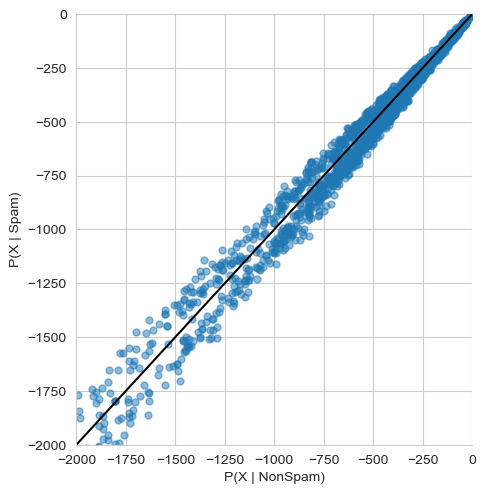

In [261]:
# Chart styling
sns.set_style("whitegrid")
labels = "Actual Category"

summary_df = pd.DataFrame({yaxis_label: joint_log_spam, xaxis_label: joint_log_ham,
                         labels: y_test})

sns.lmplot(x=xaxis_label, y=yaxis_label, data=summary_df, fit_reg=False,
          scatter_kws={"alpha":0.5,"s":25}) #fit_reg =to remove regression line
plt.xlim([-2000,1])
plt.ylim([-2000,1])
plt.plot(linedata, linedata, color = "black")

plt.show()

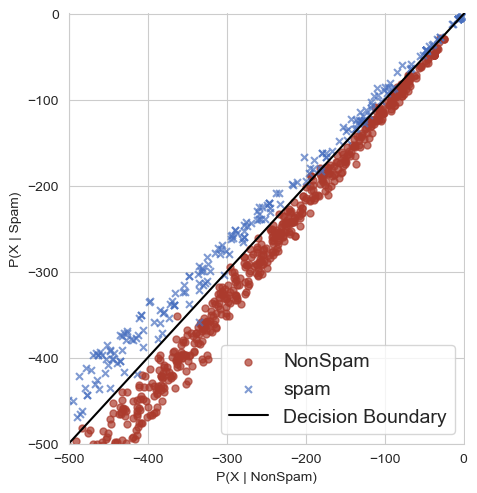

In [265]:
my_colours = ["#AB3A2C","#4A71C0"]

sns.lmplot(x=xaxis_label, y=yaxis_label, data=summary_df, fit_reg=False, legend=False,
          scatter_kws={"alpha":0.7,"s":25}, hue=labels, markers=["o","x"], palette=my_colours) #fit_reg =to remove regression line
plt.xlim([-500,1])
plt.ylim([-500,1])
plt.plot(linedata, linedata, color = "black")

plt.legend(("NonSpam","spam","Decision Boundary"), loc= "lower right", fontsize=14)
plt.show()

### False Positives and False Negatives

In [268]:
np.unique(prediction, return_counts = True)

(array([False,  True]), array([1129,  610], dtype=int64))

In [270]:
true_pos = (y_test == 1) & (prediction == 1) # & bitwise AND operator

In [272]:
true_pos.sum()

591

In [274]:
false_pos = (y_test == 0) & (prediction == 1) # & bitwise AND operator
false_pos.sum()

19

In [276]:
false_neg = (y_test == 1) & (prediction == 0) # & bitwise AND operator
false_neg.sum()

13

## Recall score

In [281]:
recall_score = true_pos.sum() / (true_pos.sum() + false_neg.sum())
print("Recall score is {:.2%}".format(recall_score))

Recall score is 97.85%


## Precision score

In [284]:
precision_score = true_pos.sum() / (true_pos.sum() + false_pos.sum())
print("Precision Score is {:.3} ".format(precision_score))

Precision Score is 0.969 


## F-Score or F1 Score

In [288]:
f1_score = 2*(precision_score * recall_score) / (precision_score + recall_score)
print("F-Score is {:2}".format(f1_score))

F-Score is 0.9736408566721582
